In [1]:
import torch
import torch.nn as nn
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage
import torch.nn.functional as F

import time
import copy
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
import os
# os.environ['http_proxy'] = "" 
# os.environ['https_proxy'] = ""
device_id = 0
torch.cuda.set_device('cuda:%d' % device_id)

In [3]:
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from piecewise_rectified_flow.src.scheduler_perflow import PeRFlowScheduler
import types

pipe = StableDiffusionPipeline.from_pretrained("/root/wuyujia_proj/RectifID/models/perflow-sd15-dreamshaper", safety_checker=None, torch_dtype=torch.float16, local_files_only=True)
# pipe = StableDiffusionPipeline.from_pretrained("hansyan/perflow-sd15-realisticVisionV51", safety_checker=None, torch_dtype=torch.float16)
# pipe = StableDiffusionPipeline.from_pretrained("hansyan/perflow-sd15-disney", safety_checker=None, torch_dtype=torch.float16)
pipe.scheduler = PeRFlowScheduler.from_config(pipe.scheduler.config, prediction_type="diff_eps", num_time_windows=4)

/root/anaconda3/envs/perflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-21 15:07:35.661800: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-21 15:07:35.676798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 15:07:35.701783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 15:07:35.709511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugi

In [4]:
for module in [pipe.vae, pipe.text_encoder, pipe.unet]:
    for param in module.parameters():
        param.requires_grad = False

pipe.to("cuda")
pipe.set_progress_bar_config(disable=True)

my_forward = pipe.__call__.__wrapped__

In [5]:
from transformers import AutoImageProcessor, AutoModel, OwlViTProcessor, OwlViTForObjectDetection, AutoProcessor
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

detector_processor = OwlViTProcessor.from_pretrained('google/owlvit-base-patch32',local_files_only=True)
detector_processor2 = AutoProcessor.from_pretrained('google/owlvit-base-patch32',local_files_only=True)
detector = OwlViTForObjectDetection.from_pretrained('google/owlvit-base-patch32',local_files_only=True).to('cuda')
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base',local_files_only=True)
model = AutoModel.from_pretrained('facebook/dinov2-base',local_files_only=True).to('cuda')
for param in model.parameters():
    param.requires_grad_(False)

OPENAI_CLIP_MEAN = torch.tensor(OPENAI_CLIP_MEAN).to('cuda')
OPENAI_CLIP_STD = torch.tensor(OPENAI_CLIP_STD).to('cuda')

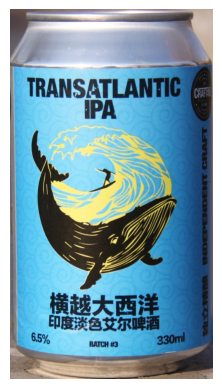

In [6]:
from PIL import Image
import torchvision.transforms.functional as TF
import kornia

ref = 'can'
# ref = 'cat'
# ref = 'dog'
# ref = 'dog3'

extract_name = lambda f: ''.join([i for i in f.replace('_', ' ') if not i.isdigit()])

ref_text = 'a photo of a %s' % extract_name(ref)
ref_image = Image.open('assets/%s_00.jpg' % ref)

ref_image = ref_image.convert("RGB")

with torch.no_grad():
    ref_image_detector_processed = detector_processor(text=ref_text, images=ref_image, return_tensors="pt")
    ref_image_detector_processed = {a: x.to('cuda') for a, x in ref_image_detector_processed.items()}
    detector_outputs = detector(**ref_image_detector_processed)
    target_sizes = torch.Tensor([ref_image.size[::-1]])
    results = detector_processor.post_process_object_detection(outputs=detector_outputs, target_sizes=target_sizes)
    box = results[0]['boxes'][results[0]['scores'].argmax()].tolist()

    ref_image_cropped = ref_image.crop(box)
    ref_image_processed = processor(images=ref_image_cropped, return_tensors="pt")['pixel_values'].to('cuda')
    ref_embedding = model(ref_image_processed)[0][:, 0]

plt.imshow(ref_image_cropped)
plt.axis("off")
plt.show()

In [7]:
from diffusers.utils.torch_utils import randn_tensor

generator = torch.manual_seed(42)

latents = nn.Parameter(randn_tensor((4, 4, 64, 64), generator=generator, device=pipe._execution_device, dtype=pipe.text_encoder.dtype))
latents0 = latents.data[:1].clone()
optimizer = torch.optim.SGD([latents], 2)  # 1 or 2

In [8]:
# live subject & object
# prompt = 'a %s in the jungle'
# prompt = 'a %s in the snow'
# prompt = 'a %s on the beach'
# prompt = 'a %s on a cobblestone street'
# prompt = 'a %s on top of pink fabric'
# prompt = 'a %s on top of a wooden floor'
# prompt = 'a %s with a city in the background'
# prompt = 'a %s with a mountain in the background'
# prompt = 'a %s with a blue house in the background'
# prompt = 'a %s on top of a purple rug in a forest'
# prompt = 'a red %s'
# prompt = 'a purple %s'
# prompt = 'a shiny %s'
# prompt = 'a wet %s'
# prompt = 'a cube shaped %s'

# live subject
# prompt = 'a %s wearing a red hat'
# prompt = 'a %s wearing a santa hat'
# prompt = 'a %s wearing a rainbow scarf'
# prompt = 'a %s wearing a black top hat and a monocle'
# prompt = 'a %s in a chef outfit'
# prompt = 'a %s in a firefighter outfit'
# prompt = 'a %s in a police outfit'
# prompt = 'a %s wearing pink glasses'
# prompt = 'a %s wearing a yellow shirt'
# prompt = 'a %s in a purple wizard outfit'

# object
# prompt = 'a %s with a wheat field in the background'
# prompt = 'a %s with a tree and autumn leaves in the background'
prompt = 'a %s with the Eiffel Tower in the background'
# prompt = 'a %s floating on top of water'
# prompt = 'a %s floating in an ocean of milk'
# prompt = 'a %s on top of green grass with sunflowers around it'
# prompt = 'a %s on top of a mirror'
# prompt = 'a %s on top of the sidewalk in a crowded street'
# prompt = 'a %s on top of a dirt road'
# prompt = 'a %s on top of a white rug'

prompt = prompt % extract_name(ref)

  0%|          | 0/51 [00:00<?, ?it/s]

loss: tensor([95.5116], device='cuda:0') tensor(299.2500, device='cuda:0', dtype=torch.float16)
grad: tensor([106.4375,  64.8125,  25.7656,   5.9727], device='cuda:0',
       dtype=torch.float16)
time: 0.4479076862335205 0.20399093627929688 0.017964601516723633 0.8784337043762207 0.001871347427368164


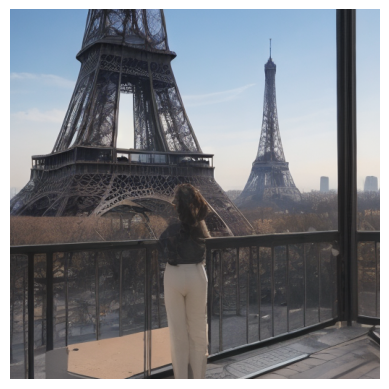

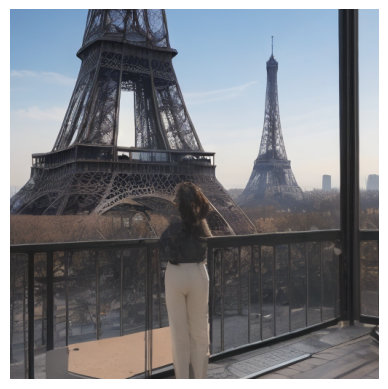

 20%|█▉        | 10/51 [00:14<00:58,  1.44s/it]

loss: tensor([94.6477], device='cuda:0') tensor(246.1250, device='cuda:0', dtype=torch.float16)
grad: tensor([185.0000,  38.8750,  10.4453,   5.5547], device='cuda:0',
       dtype=torch.float16)
time: 0.34851980209350586 0.2174971103668213 0.011518478393554688 0.8576240539550781 0.0015149116516113281


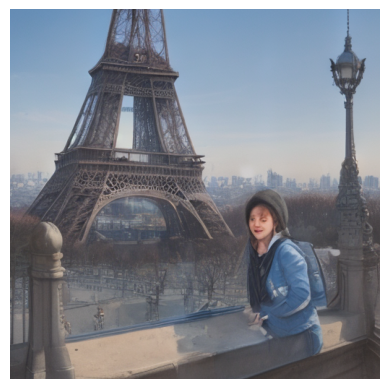

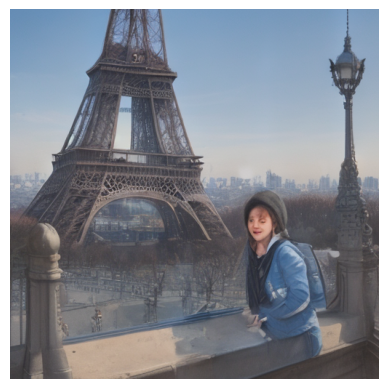

 39%|███▉      | 20/51 [00:29<00:44,  1.45s/it]

loss: tensor([91.4570], device='cuda:0') tensor(213.8750, device='cuda:0', dtype=torch.float16)
grad: tensor([21.0781, 11.8594,  6.4609,  4.7969], device='cuda:0',
       dtype=torch.float16)
time: 0.35125279426574707 0.21726512908935547 0.011493444442749023 0.8624887466430664 0.001584768295288086


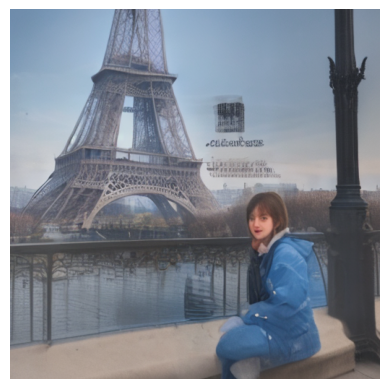

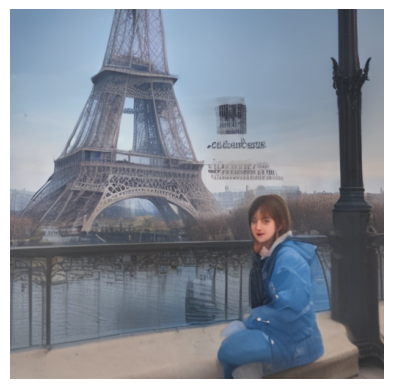

 59%|█████▉    | 30/51 [00:44<00:30,  1.45s/it]

loss: tensor([89.3366], device='cuda:0') tensor(237., device='cuda:0', dtype=torch.float16)
grad: tensor([161.7500, 104.6875,  82.7500,  47.7812], device='cuda:0',
       dtype=torch.float16)
time: 0.3544008731842041 0.21830177307128906 0.011461973190307617 0.8708846569061279 0.0015895366668701172


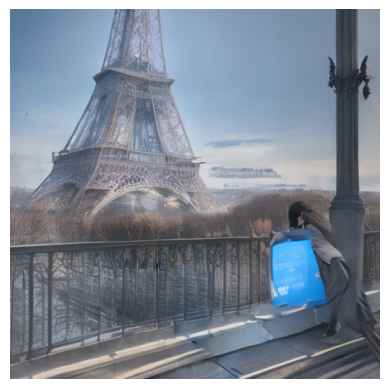

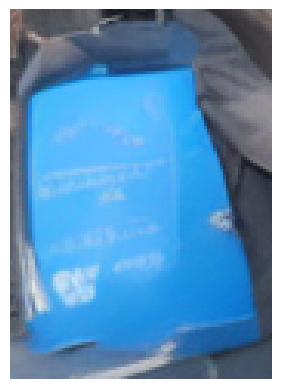

 78%|███████▊  | 40/51 [00:58<00:16,  1.47s/it]

loss: tensor([81.1504], device='cuda:0') tensor(210.6250, device='cuda:0', dtype=torch.float16)
grad: tensor([126.3750,  54.6562,  31.0781,  26.8750], device='cuda:0',
       dtype=torch.float16)
time: 0.3575417995452881 0.21291661262512207 0.011309385299682617 0.8762691020965576 0.0016994476318359375


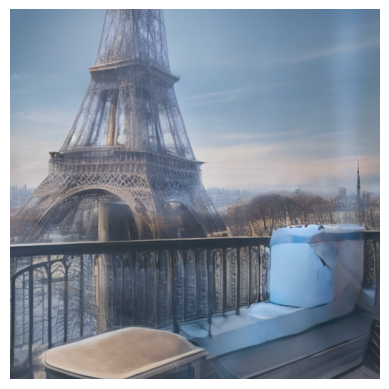

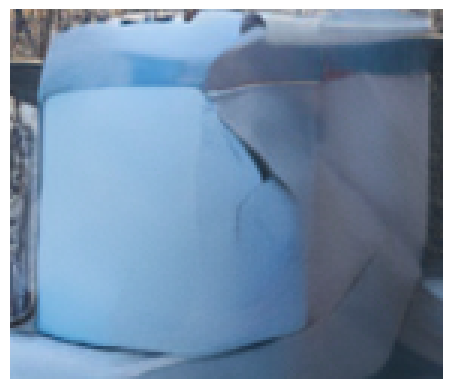

 98%|█████████▊| 50/51 [01:14<00:01,  1.49s/it]

loss: tensor([70.9762], device='cuda:0') tensor(233.8750, device='cuda:0', dtype=torch.float16)
grad: tensor([55.0312, 48.9688, 42.0312, 23.4062], device='cuda:0',
       dtype=torch.float16)
time: 0.36775755882263184 0.21776032447814941 0.011473894119262695 0.9051551818847656 0.0016472339630126953


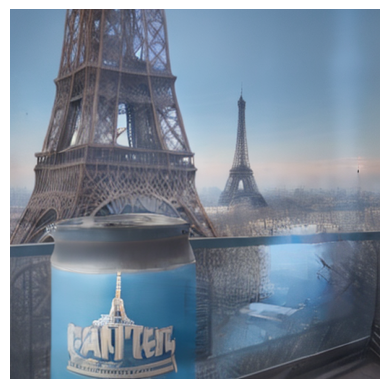

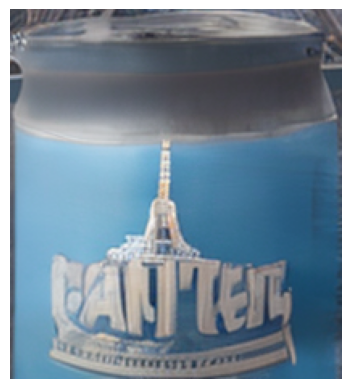

100%|██████████| 51/51 [01:15<00:00,  1.49s/it]


In [9]:
latents_last = latents.data.clone()
latents_last_e = latents.data.clone()
initialized_i = -1

def callback(self, i, t, callback_kwargs):
    global latents_last, latents_last_e, initialized_i
    if initialized_i < i:
        latents[i:(i+1)].data.copy_(callback_kwargs['latents'])
        latents_last[i:(i+1)].copy_(callback_kwargs['latents'])
        latents_last_e[i:(i+1)].copy_(callback_kwargs['latents'])
        initialized_i = i
    if i < 3:
        callback_kwargs['latents'] += latents[(i+1):(i+2)] - latents[(i+1):(i+2)].detach()
    latents_e = callback_kwargs['latents'].data.clone()
    callback_kwargs['latents'] += latents_last[i:(i+1)].detach() - callback_kwargs['latents'].detach()
    callback_kwargs['latents'] += latents_e.detach() - latents_last_e[i:(i+1)].detach()
    # callback_kwargs['latents'] += latents[i:(i+1)].detach() - latents_last_e[i:(i+1)].detach()
    callback_kwargs['latents'] += (latents[i:(i+1)].detach() - latents_last_e[i:(i+1)].detach()) * 0.95796674
    latents_last[i:(i+1)].copy_(callback_kwargs['latents'])
    latents_last_e[i:(i+1)].data.copy_(latents_e)
    latents[i:(i+1)].data.copy_(latents_e)
    return callback_kwargs

for epoch in tqdm(range(51)):
    t0 = time.time()
    image = my_forward(pipe, prompt=prompt, num_inference_steps=4, guidance_scale=3.0, latents=latents0+latents[:1]-latents[:1].detach(), output_type='pt', return_dict=False, callback_on_step_end=callback)[0][0]
    t1 = time.time()

    with torch.no_grad():
        image_detector_processed = detector_processor2(images=(image * 255).int(), query_images=ref_image_cropped, return_tensors="pt")
        image_detector_processed = {a: x.to('cuda') for a, x in image_detector_processed.items()}
        detector_outputs = detector.image_guided_detection(**image_detector_processed)
        target_sizes = torch.Tensor([image.shape[1:]])
        results = detector_processor2.post_process_image_guided_detection(outputs=detector_outputs, target_sizes=target_sizes)
        box = results[0]['boxes'][results[0]['scores'].argmax()].tolist()
        box = [min(max(round(b), 0), 512) for b in box]
    image_cropped = TF.crop(image, box[1], box[0], box[3]-box[1], box[2]-box[0])
    t2 = time.time()

    image_processed = (F.interpolate(image_cropped.unsqueeze(0), (224, 224)) - OPENAI_CLIP_MEAN[..., np.newaxis, np.newaxis]) / OPENAI_CLIP_STD[..., np.newaxis, np.newaxis]
    embedding = model(image_processed)[0][:, 0]
    loss1 = (1 - F.cosine_similarity(embedding, ref_embedding)) * 100
    loss2 = F.l1_loss(F.interpolate(image_cropped.unsqueeze(0), (224, 224)), F.interpolate(TF.to_tensor(ref_image_cropped).half().to('cuda').unsqueeze(0), (224, 224))) * 1000  # optional for object
    loss = loss1 + loss2  # for object
    # loss = loss1 + loss2 * 0  # for live subject
    t3 = time.time()

    optimizer.zero_grad()
    loss.backward()
    t4 = time.time()
    grad_norm = latents.grad.reshape(4, -1).norm(dim=-1)
    latents.grad /= grad_norm.reshape(4, 1, 1, 1).clamp(min=1)
    optimizer.step()
    t5 = time.time()

    if epoch % 10 == 0:
        print('loss:', loss1.data, loss2.data)
        print('grad:', grad_norm)
        print('time:', t1-t0, t2-t1, t3-t2, t4-t3, t5-t4)
        plt.imshow(np.array(image.permute(1, 2, 0).detach().cpu() * 255, dtype=np.uint8))
        plt.axis("off")
        plt.show()
        plt.imshow(np.array(image_cropped.permute(1, 2, 0).detach().cpu() * 255, dtype=np.uint8))
        plt.axis("off")
        plt.show()
    del image